# Structural Analysis of Protein Ensembles

This notebook does the following:
- Creates a protein structural ensemble from the PDB structures prepared in [this notebook](../../1_Download_and_prepare_protein_ensembles/4_Prepare_proteins_using_pdb4amber.ipynb). The file is saved into `.dcd` and `.pdb` format files. 
    - Structures are aligned using the $C \alpha$ atoms of the residues comprising the protein's pocket.
- The `.pdb` file is used as input for `POVME` to compute the volume and the shape of the protein's pocket.
- Pair-wise RMSD is computed among all protein conformations.
- Classical Multidimensional Scaling Analysis (cMDS) is performed using the RMSD matrix as input.

In [3]:
import pandas as pd
import numpy as np
import pytraj as pyt
import nglview as nv
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from prody import *
import sys
sys.path.insert(0, '../..')
from helper_modules.get_cocristalized_ligands \
     import get_pocket_ligand, PocketResidues
sns.set(style='ticks', font_scale = 1.2)

## Protein information dataframe

In [4]:
prot_name = 'egfr'
df_prot_file = '../1_Download_and_prepare_protein_ensembles/TABLA_MTDATA_EGFR_175_crys_LIGS_INFO.json'
df_prot = pd.read_json(df_prot_file)
df_prot.head()

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass
1m14,structure of the epidermal growth factor \nrec...,2002-09-04,1,A,2.60,1.000,23.058,2,"[695, 236]","[[1, 695], [975, 1210]]",0,[],None,NaN
1m17,structure of the epidermal growth factor \nrec...,2002-09-04,1,A,2.60,1.000,23.058,2,"[695, 236]","[[1, 695], [975, 1210]]",1,[AQ4],AQ4,370.253100
1xkk,a unique structure for epidermal growth factor...,2004-12-07,1,A,2.40,0.936,19.256,5,"[701, 4, 4, 8, 260]","[[1, 701], [734, 737], [750, 753], [867, 874],...",2,"[FMM, PO4]",FMM,554.851103
2eb2,structural basis for the altered drug sensitiv...,2008-02-12,1,A,2.50,0.980,20.661,5,"[695, 3, 1, 1, 260]","[[1, 695], [721, 723], [749, 749], [866, 866],...",0,[],None,NaN
2eb3,structural basis for the altered drug sensitiv...,2008-02-12,1,A,2.84,0.941,19.835,4,"[695, 1, 14, 260]","[[1, 695], [721, 721], [862, 875], [951, 1210]]",1,[ANP],ANP,489.061283


## Protein structural ensemble

In [5]:
%run ../../helper_modules/protein_subsequences.py

In [6]:
# Create a trajectory file using the protein ensemble
path_to_pdb_files = '../1_Download_and_prepare_protein_ensembles/pdb_structures/pdb_prepared/*'

# Load all protein structures to a single trajectory
crys_traj = pyt.io.iterload(filename = path_to_pdb_files)

In [7]:
print(f' Number of conformations: {crys_traj.n_frames}\n',
      f'Number of atoms per frame: {crys_traj.n_atoms}.')

 Number of conformations: 175
 Number of atoms per frame: 3869.


### Save protein Ensemble as PDB trajectory

- **Alingment using Pocket subsequence**: PDB format as was used to compute Volumne using POVME3, check folder `./POVME_results`

In [8]:
# Use a reference structure to visualize the pocket residues
prot_name = 'egfr'
ref_struc_id      = '7a2a'
ref_ligand_name_1 = '57N'
ref_ligand_name_2 = '7G9'

pkt_info_1 = PocketResidues(ref_struc_id, ref_ligand_name_1)
pkt_info_2 = PocketResidues(ref_struc_id, ref_ligand_name_2)

pocket_residues_str_1 = pkt_info_1.get_pocket_residues_as_list().split(' ')
pocket_residues_str_2 = pkt_info_2.get_pocket_residues_as_list()
pocket_residues_str_2 = pocket_residues_str_2.split(' ')

# Merge the values
pocket_residues_str = sorted(list(set(pocket_residues_str_1 + pocket_residues_str_2)))
pocket_residues_str = ' '.join(pocket_residues_str)

print('Indices of pocket redsidues:', pocket_residues_str)

Indices of pocket redsidues: 717 718 719 720 723 725 726 727 728 738 742 743 744 745 746 747 758 759 760 761 762 763 764 766 767 769 774 775 776 777 778 779 780 786 787 788 789 790 791 792 793 794 795 796 797 798 799 800 801 803 840 841 842 843 844 845 853 854 855 856 857 858


In [9]:
# update pocket residues positions to match the positions in the modelled strucutres
pocket_residues_UPDATED = [str(int(i) - 710) for i in pocket_residues_str.split(' ')]
pocket_residues_UPDATED_str = ','.join(pocket_residues_UPDATED)
pocket_residues_UPDATED_str

'7,8,9,10,13,15,16,17,18,28,32,33,34,35,36,37,48,49,50,51,52,53,54,56,57,59,64,65,66,67,68,69,70,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,93,130,131,132,133,134,135,143,144,145,146,147,148'

In [10]:
pkt_str_mask = f":{pocket_residues_UPDATED_str}&(@CA)"
pocket_alg = pyt.align(crys_traj, mask = pkt_str_mask)
# Save the traj: This traj was used to compute POVME, check folder ./POVME_results
pyt.write_traj(f'./PDB_{crys_traj.n_frames}_{prot_name}_POCKET_ALL.pdb', 
               pocket_alg, 
               options = 'model',
               overwrite = True)

# Save the traj as dcd file to upload to github
pyt.write_traj(f'./PDB_{crys_traj.n_frames}_{prot_name}_POCKET_ALL.dcd', 
               pocket_alg,
               overwrite = True )

### Compute the center of mass of the pocket using its residues

In [11]:
mask = f':{pocket_residues_UPDATED_str}'

center_geo = pyt.center_of_geometry(traj = pocket_alg, 
                                    mask = mask, 
                                    dtype = 'ndarray', 
                                    frame_indices = None)

center_mass = pyt.center_of_mass(traj = pocket_alg, 
                                 mask = mask, 
                                 dtype ='ndarray', 
                                 frame_indices = None)

print('Center of geometry (mean):', 
      np.round(center_geo.mean(axis  = 0)))
print('Center of mass (mean):', 
      np.round(center_mass.mean(axis = 0)))

Center of geometry (mean): [-42.  -6.   2.]
Center of mass (mean): [-43.  -6.   2.]


In [12]:
view   = nv.show_pytraj(pocket_alg)
center = np.round(center_mass.mean(axis = 0), 0).tolist()
view.add_representation('licorice', selection = ':2,4')
view.shape.add_sphere(center, [0,0,3,0.2], 12)
view.update_representation(component  = 1, 
                           repr_index = 0, 
                           opacity    = 0.5)
view

NGLWidget(max_frame=174)

In [13]:
view = pkt_info_1.visualize_pocket()
view.shape.add_sphere(center, [0,0,3,0.2], 14)
view.update_representation(component  = 2, 
                           repr_index = 0, 
                           opacity    = 0.5)
view

NGLWidget()

- **Alingment using Pocket subsequence**: PDB format as was used to compute Volumne using POVME3, check folder `./POVME_results`

In [14]:
print(F'PDBID used as reference structure: {ref_struc_id}')
# Use a reference structure to identify the secondary structure residues
header      = parsePDB(ref_struc_id, header = True, 
                       model = 0,
                       chain = 'A')
structure   = parsePDB(ref_struc_id, folder = './', chain = 'A')
sec_sctr    = assignSecstr(header, structure.select('protein and chain A')).getSecstrs()
sec_sctr_HE = structure.select(F'secondary H E and calpha and chain A').getResnums()

sec_sctr_res_list = np.unique(sec_sctr_HE).tolist()
sec_sctr_res_str  = ','.join(map(str, sec_sctr_res_list))

# Only for the EGFR protein
# Use a modeled structure to limit the residue numbers
ref_modeled = parsePDB('../1_Download_and_prepare_protein_ensembles/pdb_structures/pdb_prepared/7a2a_ENS.pdb')
ref_mod_resnums = np.unique(ref_modeled.getResnums())
# Find the intersection
sec_sctr_res_list_UPDATED = [i - 710 for i in sec_sctr_res_list] # update resnumbers
sec_sctr_res_list_UPDATED = list(set(ref_mod_resnums) & set(sec_sctr_res_list_UPDATED))
sec_sctr_residues_UPDATED_str = ','.join([str(i) for i in sec_sctr_res_list_UPDATED])

print(F'{len(sec_sctr_res_list_UPDATED)} residues belong \
to the secondary structure of the {prot_name.upper()} protein.')

sec_sctr_residues_UPDATED_str

PDBID used as reference structure: 7a2a
134 residues belong to the secondary structure of the EGFR protein.


'2,3,4,5,6,7,8,9,10,14,15,16,17,18,19,20,21,30,31,32,33,34,35,36,37,46,47,48,49,50,51,52,53,54,55,56,57,58,69,70,71,72,76,77,78,79,80,81,87,88,89,90,91,92,93,94,95,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,133,134,135,136,137,140,141,142,143,172,173,174,175,176,177,178,179,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,212,213,214,215,216,217,218,219,230,231,232,233,234,235,236,237,238,239,240,241'

In [15]:
# Perform the alignment
sec_str_mask = f':{sec_sctr_residues_UPDATED_str}&(@CA)'
sec_str_alg = pyt.align(crys_traj, mask = sec_str_mask)

# Save the traj: This traj was used to compute POVME, check folder ./POVME_results
pyt.write_traj(f'./PDB_{crys_traj.n_frames}_{prot_name}_SECSTRUC_ALL.pdb', 
               sec_str_alg,
               options='model',
               overwrite=True)

# Save the traj as dcd file to upload to github
pyt.write_traj(f'./PDB_{crys_traj.n_frames}_{prot_name}_SECSTRUC.dcd', 
               sec_str_alg,
               overwrite=True)

In [16]:
view = nv.show_pytraj(sec_str_alg)
view.clear_representations()
view.add_representation('cartoon', 
                        color = 'white')
view.add_representation('cartoon', 
                        selection = "%s" % sec_sctr_res_list_UPDATED, 
                        color = 'red')
view

NGLWidget(max_frame=174)

## Pocket Volume information
- Add Pocket Volume information computed by POVME3 to the protein dataframe

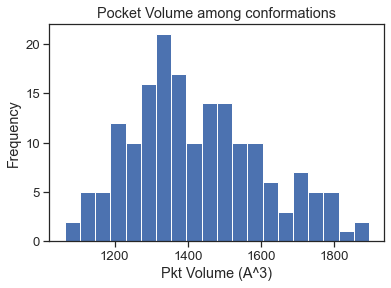

In [17]:
pocket_vol_file = './POVME3_results/Pocket_alignment/res_volumes.tabbed.txt'
# Keep only the Volume column from the POVME3 results
df = pd.read_csv(pocket_vol_file, sep='\t', 
                 header  = None, 
                 names   = ['conf_num', 'volume'])[['volume']]
# Add the volumen information to the main dataframe
df_prot['pocket_volume'] = df.volume.values
ax = df_prot.pocket_volume.plot.hist(bins = 20)
ax.set(title  = 'Pocket Volume among conformations', 
       xlabel = 'Pkt Volume (A^3)')
plt.show()

## Classical Multidimensional Scaling

In [18]:
%run ../../helper_modules/MDS.py

#### cMDS: Using RMSD as distance metric


In [19]:
# Compute the distance matrices

# for EGFR only
# update the residues positions to match the modeled chains

pair_rmsd_sec = pyt.pairwise_rmsd(traj   = crys_traj,
                                  mask   = sec_str_mask, 
                                  metric ='rms')

pair_rmsd_pkt = pyt.pairwise_rmsd(traj   = crys_traj,
                                  mask   = pkt_str_mask, 
                                  metric ='rms')

In [20]:
# Compute cMDS
mds_sec = cMDS(pair_rmsd_sec)[0]
mds_pkt = cMDS(pair_rmsd_pkt)[0]

#### Visualize the projections

In [21]:
def plot_subspace(x, y, title = '', **kwargs):
    '''A simple scatterplot function'''
    fig, ax = plt.subplots(figsize = (6, 6))
    sns.scatterplot(x = x, y = y, 
                    alpha = 0.6,
                    linewidth = 0, 
                    color = '#02A298',
                    **kwargs
                   )
    ax.set_title(title)
    ax.set(xlabel = 'Dim. 1', ylabel = 'Dim. 2')
    ax.axvline(0, ls = ':', color = 'gray')
    ax.axhline(0, ls = ':', color = 'gray')
    ax.grid()
    plt.show()

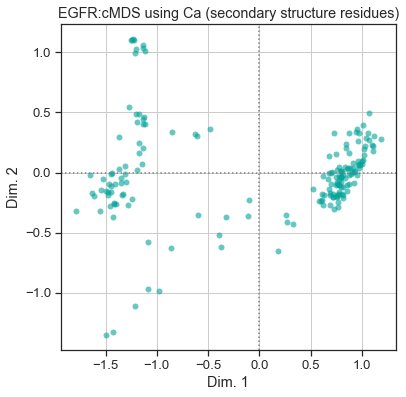

In [22]:
# Visualize the projection
x, y = mds_sec[:2]
plot_subspace(x, y, 
    title = f'{prot_name.upper()}:' + 
             'cMDS using Ca (secondary structure residues)')

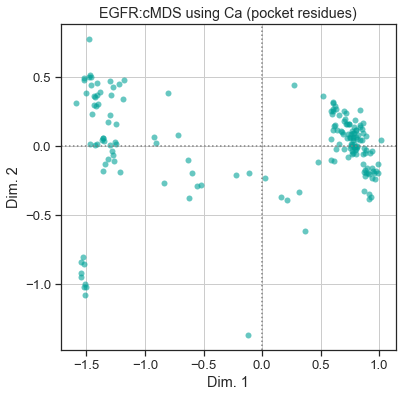

In [23]:
# Visualize the projection
x, y = mds_pkt[:2]
plot_subspace(x, y, 
    title = f'{prot_name.upper()}:' +
             'cMDS using Ca (pocket residues)')

#### cMDS: Using pocket shape similarity

In [24]:
# Load POVME3 results
path_povme_results = './POVME3_results/Pocket_alignment/'
vol_tan_mtx = pd.read_csv(f'{path_povme_results}' + 
                           '/POVME_Tanimoto_matrix.csv', 
                           header=None)

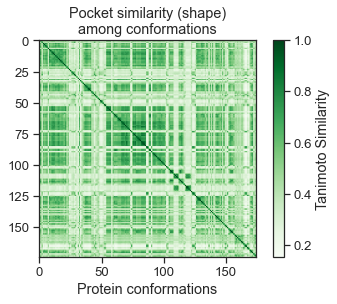

In [25]:
# The following figure shows the 
# Tanimoto Similarity among pockets saphes
fig, ax = plt.subplots()
plt.imshow(vol_tan_mtx, cmap = 'Greens')
ax.set(xlabel = 'Protein conformations',
       title  = "Pocket similarity (shape)\n" + \
                "among conformations"
      )
plt.colorbar(label = 'Tanimoto Similarity')
plt.show()

In [26]:
# cMDS using Tanimoto
# Compute a dissimilarity matrix
dism_mtx    = 1 - vol_tan_mtx
mds_vol_pkt = cMDS(dism_mtx)[0]

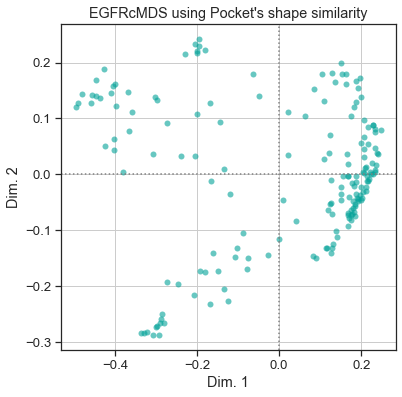

In [27]:
# Visualize the projection
x, y = mds_vol_pkt[:2]
plot_subspace(x, y, 
    title = f"{prot_name.upper()}" + 
             "cMDS using Pocket's shape similarity")

## Selected conformations

In [28]:
np.random.seed(42)
pdb_ids_selected = np.random.choice(df_prot.index, 64, 
                                    replace = False)
pdb_ids_selected

array(['6s9d', '6jx0', '5gmp', ..., '2itq', '5em8', '5c8m'], dtype=object)

In [29]:
def plot_subspace(x, y, title = '', **kwargs):
    '''A simple scatterplot function'''
    fig, ax = plt.subplots(figsize = (6, 6))
    sns.scatterplot(x = x, 
                    y = y, 
                    alpha     = 0.6,
                    linewidth = 0, 
                    color = '#02A298',
                    **kwargs
                   )
    ax.set_title(title)
    ax.set(xlabel    = 'Dim. 1', 
           ylabel    = 'Dim. 2')
    ax.axvline(0, ls = ':', 
               color = 'gray')
    ax.axhline(0, ls = ':', 
               color = 'gray')
    ax.grid()
    plt.show()

In [30]:
df_prot['selected'] = 0
df_prot.loc[pdb_ids_selected] = 1

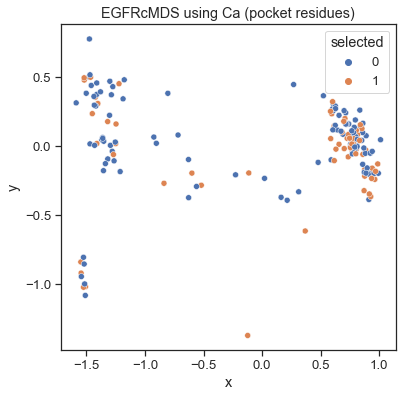

In [31]:
x, y = mds_pkt[:2]
data = pd.DataFrame({
    'x': x, 'y': y,
    'selected': df_prot['selected'] 
})

fig, ax = plt.subplots(figsize = (6, 6))
sns.scatterplot(data = data, x = 'x', y = 'y', hue = 'selected')
ax.set(title = f"{prot_name.upper()}" + 
                "cMDS using Ca (pocket residues)")
plt.show()

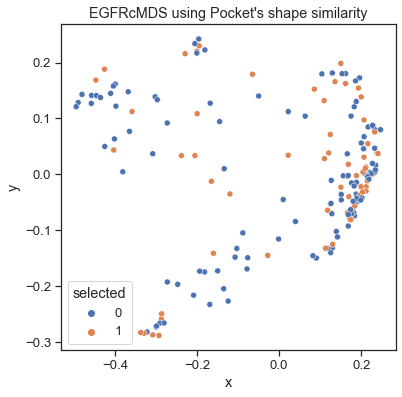

In [32]:
x, y = mds_vol_pkt[:2]
data = pd.DataFrame({
    'x': x, 'y': y,
    'selected': df_prot['selected'] 
})

fig, ax = plt.subplots(figsize = (6, 6))
sns.scatterplot(data = data, 
                x    = 'x', 
                y    = 'y', 
                hue  = 'selected')
ax.set(title = f"{prot_name.upper()}" + 
                "cMDS using Pocket's shape similarity")
plt.show()

## Save the projections

In [33]:
df_dims = pd.DataFrame([mds_sec[0], mds_sec[1],
                        mds_pkt[0], mds_pkt[1],
                        mds_vol_pkt[0], mds_vol_pkt[1]]).T

# Set names
colnames = ['mds_sec_x', 'mds_sec_y',
            'mds_pkt_x', 'mds_pkt_y',
            'mds_vol_pkt_x', 'mds_vol_pkt_y',
           ]

# Set the names
df_dims.columns = colnames
# Set index
df_dims.index = df_prot.index
# Save to file
df_dims.to_pickle('./df_PROTEINS_DIMS_reduced_TABLE.obj')

Fnished!